# Parte computacional da questão 1.2


## Questão 1.2.1

Instalando bibliotecas 

In [8]:
%pip install numpy matplotlib plotly pandas

Note: you may need to restart the kernel to use updated packages.


Vamos começar determinando algumas bibliotecas que iremos usar, e definindo algumas funções 

In [9]:


import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt


#phi latitude 
#teta longitude
def esfe_cart(phi,teta,r): # Leva das coordenadas esféricas em coordenadas cartesianas 
    x = -r * np.cos(phi) * np.cos(teta)
    y = -r * np.cos(phi) * np.sin(teta)
    z = r * np.sin(phi)
    return x,y,z


def ler_coordenadas(file_name): # Função simples para ler .txt
    with open(file_name, 'r') as f:
        lat =[]
        long =[]
        for line in f:
            
            b,a = line.split()
            lat.append(float(a))
            long.append(float(b))
    return lat, long 

def projecao_mercator(phi,teta): # Realiza a projeção
    return teta, np.log(np.tan(phi/2+np.pi/4))

def calcular_comprimento(curva, r, Fechada = True):
    
    r_bra = curva
    produto_interno = np.sum(r_bra[:, :-1]* r_bra[:, 1:], axis=0)
    #r_bra[:, :-1] percorrer a matriz tirando o ultimo ponto e r_bra[:, 1:] percorrer tirando o primeiro ponto para desalinhar e realizar o produto
    
    if Fechada:
        ultimo_produto = np.sum(r_bra[:, :1] * r_bra[:, -1:],axis=0) # Produto que falta

        produto_interno = np.concatenate(
            [produto_interno, ultimo_produto]
        )
    
    angulos = np.arccos(np.clip(produto_interno/r**2,-1,1))
    # O np.clip evita os erros numéricos de retornar valores fora do intervalo [-1,1] 
    return np.sum(angulos*r)


Em seguida vamos determinar as coordenadas importantes para nosso problema.

In [ ]:
#----------------------------------------------------------------------
#----------- Coordenadas ----------------------------------------------
# -----------------------------------------------------------------------


# Lendo as coordenadas da fronteira do mapa do brasil
lat, long = ler_coordenadas("border_main.txt")
lat = np.array(lat)
long = np.array(long)

# Transformando a latitude e longintude em radianos
phi_bra = lat*np.pi/180 
teta_bra = long*np.pi/180

# Criando alguns pontos na suprefície da esfera para visualização 
teta_esf = np.linspace(-np.pi, np.pi, 100)
phi_esf = np.linspace(-np.pi/2, np.pi/2, 50)
teta_esf, phi_esf = np.meshgrid(teta_esf,phi_esf)
r= 1

# Levando para coordenada cartesiana 
x_esf, y_esf, z_esf = esfe_cart( phi_esf,teta_esf, r)
x_bra_f, y_bra_f, z_bra_f = esfe_cart( phi_bra, teta_bra, r)

# Rio de janeiro coordenada 
lat_rj = -22.90
lon_rj = -43.20
phi_rj = lat_rj * np.pi/ 180
teta_rj = lon_rj * np.pi/ 180

# Brisbane Coordenada 
lat_bb = -27.47
lon_bb = 153.02
phi_bb = lat_bb * np.pi/ 180
teta_bb = lon_bb * np.pi/ 180

# Posição em coordenada cartesiana do rio de brisbane 
x_rj_bb, y_rj_bb, z_rj_bb = esfe_cart(np.array([phi_rj, phi_bb]), np.array([teta_rj, teta_bb]), r)

In [11]:
#----------------------------------------------------------------------
#----------- Laxodromia brisbane ao rio -------------------------------
#----------------------------------------------------------------------

x_merc_rj, y_merc_rj = projecao_mercator(phi_rj, teta_rj) # Coordenada x e y do rio na projeção
x_merc_bb, y_merc_bb = projecao_mercator(phi_bb, teta_bb)  # Coordenada x e y de brisbane na projeção


# Rete entre rio e brisbane.
x_laxo = np.linspace(x_merc_rj, x_merc_bb,100 ) 
y_laxo = np.linspace(y_merc_rj, y_merc_bb,100 )


# Voltar para a esfera
phi_laxo = np.arcsin(np.tanh(y_laxo/r))
teta_laxo = x_laxo/r

x_laxo_esf, y_laxo_esf, z_laxo_esf = esfe_cart(phi_laxo, teta_laxo, r)

- Determinar, a partir do produto interno, o ângulo entre os vetores **p1** e **p2**, onde **p1**, **p2** são os vetores posição do lugar em relação ao centro da esfera.

- Em seguida, escolher um vetor unitário **u** tal que  
  $ u \cdot p_1 = 1 $, com  
  $ u = \dfrac{p_1}{\lVert p_1 \rVert} = \dfrac{p_1}{R} $.

- Agora vamos usar **p2** para construir **v** tal que  
  $ v \cdot u = 0 $.  
  Tomamos
  $$
  v
  = \frac{p_2 - (p_2 \cdot u)\,u}
         {\lVert p_2 - (p_2 \cdot u)\,u \rVert}.
  $$

- Agora resta parametrizar a curva usando a base **u** e **v**:
  $$
  \text{curva}(t)
  = R \bigl( u \cos t + v \sin t \bigr),
  \qquad
  t \in [0, \theta].
  $$

- O ângulo entre os dois pontos é dado por
  $
  \cos(\theta) = u \cdot v.
  $


In [ ]:
#----------------------------------------------------------------------
#----------- Geodésica brisbane ao rio --------------------------------
#----------------------------------------------------------------------

"""Vetores posição do Rio e Brisbane respectivamente. Aqui como a origem está centrada no 
centro do globo, o vetor posição é igual ao vetor pi citado antes"""

r_rj = np.array([x_rj_bb[0], y_rj_bb[0], z_rj_bb[0]])
r_bb = np.array([x_rj_bb[1], y_rj_bb[1], z_rj_bb[1]])

#
u = r_rj / np.linalg.norm(r_rj)
proj = np.dot(r_bb, u) * u
v = r_bb - proj
v = v / np.linalg.norm(v)

Theta = np.arccos(np.dot(u, r_bb))/np.linalg.norm(r_bb)

# Curva
def geodesica(t):
    return u*np.cos(t) + v*np.sin(t)

t_vals = np.linspace(0, Theta, 200)
curve = np.array([geodesica(t) for t in t_vals])

x_geo, y_geo, z_geo = curve[:,0], curve[:,1], curve[:,2]

In [ ]:
#----------------------------------------------------------------------
#----------- Plot em 3D -----------------------------------------------
#----------------------------------------------------------------------
# Boa parte desse trecho (quase tudo) é um copía e cola do código dos monitores

fig = go.Figure(data=[
    
    go.Surface(x=x_esf, y=y_esf, z=z_esf, opacity=0.7, colorscale='Blues', showscale=False),
    go.Scatter3d(x= x_bra_f, y= y_bra_f, z= z_bra_f,mode='markers',
                 marker=dict(size=1, color='red')),
    go.Scatter3d(x= x_rj_bb, y= y_rj_bb, z= z_rj_bb,mode='markers',
                 marker=dict(size=5, color='green')),
    go.Scatter3d(x= x_laxo_esf, y= y_laxo_esf, z= z_laxo_esf,mode='lines',
                  line=dict(color='blue', width=6),
        name='Laxodromia'),
    go.Scatter3d(
        x=x_geo, y=y_geo, z=z_geo,
        mode='lines',
        line=dict(color='black', width=6),
        name='Geodésica'
    )
    
])

fig.update_layout(title='Esfera com Plotly', autosize=True,
                  scene=dict(aspectmode='data')) # Mantém a proporção correta

                  # Salvar como HTML interativo
fig.write_html("esfera_plotly.html")
# Para mostrar diretamente no notebook ou em uma nova janela
#fig.show()

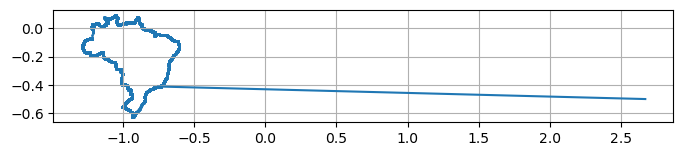

In [ ]:
#----------------------------------------------------------------------
#----------- Plot projeção --------------------------------------------
#----------------------------------------------------------------------
#Plotar projeção


#Brasil!!

plt.figure(figsize=(8,6))

plt.plot(x_laxo, y_laxo)

plt.scatter(
    projecao_mercator(phi_bra, teta_bra)[0],
    projecao_mercator(phi_bra, teta_bra)[1],
    s=1
)

plt.gca().set_aspect('equal', adjustable='box')  
plt.grid()
plt.show()

## Questão 1.2.2

Para calcular a fronteira do brasil vamos "integrar" os comprimentos de arcos de cada ponto da fronteira. 
Vamos supor que a linha que liga dois pontos próximos no dado é a geodésica. Pois dai basta calcular (pi, pj ) para obter o angulo e multiplicar pelo raio da terra. 

In [ ]:
#----------------------------------------------------------------------
#----------- Fronteira do brasil --------------------------------------------
#----------------------------------------------------------------------
r_bra = np.array([x_bra_f, y_bra_f, z_bra_f])

r_terra = 6371

'''Aqui na função usamos r =1  pois nosso vetor r_gra foi criado apartir de i_bra_f que tem módulo 1.
 Bataria também multiplica-lo por r da terra e trocar o r que é argumento da função por r_terra'''
comprimento_normalizado = calcular_comprimento(r_bra, r)
# comprimento = calcular_comprimento(r_bra*r_terra, r_terra)
comprimento = comprimento_normalizado*r_terra
print(comprimento)




24596.324220295362


## Questão 1.2.3

Vamos ler o GPX


In [15]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

# caminho do arquivo
arquivo = "travessia-petropolis-teresopolis.gpx"

# parse do XML
tree = ET.parse(arquivo)
root = tree.getroot()

# namespace do GPX
ns = {"gpx": "http://www.topografix.com/GPX/1/1"}

dados = []

for trkpt in root.findall(".//gpx:trkpt", ns):
    lat = float(trkpt.attrib["lat"])
    lon = float(trkpt.attrib["lon"])
    
    ele = trkpt.find("gpx:ele", ns)
    ele = float(ele.text) if ele is not None else None

    time = trkpt.find("gpx:time", ns)
    time = datetime.fromisoformat(time.text.replace("Z", "")) if time is not None else None

    dados.append({
        "latitude": lat,
        "longitude": lon,
        "elevacao": ele,
        "tempo": time
    })

# cria DataFrame
df = pd.DataFrame(dados)

lat_gps = df["latitude"].to_numpy()
lon_gps = df["longitude"].to_numpy()
t_gps   = df["tempo"].to_numpy()
t_sec = (df["tempo"] - df["tempo"].iloc[0]).dt.total_seconds().to_numpy()



In [ ]:
phi_gps = lat_gps*np.pi/180
teta_gps = lon_gps*np.pi/180
r =1
x_gps, y_gps, z_gps = esfe_cart(phi_gps, teta_gps, r)
r_curva = np.array([x_gps, y_gps, z_gps])
#print(np.shape(r_curva)
# fazemos a mesma coisa que a questão 1.2.2

comprimento_gps_normalizado = calcular_comprimento(r_curva, r, Fechada=False)
comprimento_gps = comprimento_gps_normalizado*r_terra
print(comprimento_gps)

fig = go.Figure(data=[
    
    
    go.Scatter3d(x= x_gps, y= y_gps, z= z_gps,mode='markers',
                 marker=dict(size=1, color='red')),

    
])

fig.update_layout(title='Esfera com Plotly', autosize=True,
                  scene=dict(aspectmode='data')) # Mantém a proporção correta

                  # Salvar como HTML interativo
fig.write_html("esfera_plotly.html")
# Para mostrar diretamente no notebook ou em uma nova janela
#fig.show()

28.729197215012306


Vamos calcular o vetor velocidade. A diferenciação de Lanczos usa uma espécie de convolução entre os pontos, da forma.
$$
r'(t) = \frac{1}{\Delta t} \sum_{k =-M}^{M} c_k \cdot r(t + k\Delta t)  
$$

Onde os coeficientes $c_k$ são antisimétricos, ou seja $c_k = - c_{-k}$ para $k$ diferente de 0. Essa soma é uma convolução entre as variáveis discretas. Por isso vamos usar o np.convolve. No nosso caso podemos dizer que $t = t_i$ e denotar da seguinte forma:
$$
r'[i] = \frac{1}{\Delta t} \sum_{k =-M}^{M} c_k \cdot r[i + k] 
$$
Que é a mesma cara de uma convolução, porém ao invez de $i-k$ temos $i+k$. Então por isso devemos inverter o array C de coeficientes.

In [ ]:
def diferentiacao(r,t, C ):
    #C deve ser da forma [-c_n, -c_n-1, ..., c_0, ..., c_n-1, c_n]
    dt = t[1] - t[0]
    v = np.array([
        np.convolve(r[i], C[::-1], mode="valid")
        for i in range(3)
    ]) / dt
    # C[::-1] faz o array ser percorrido ao contrário. e o modo válid evita fazer a convolução para bordas, onde o núcleo não encaixa em r
    return v




C = np.array([-2, -1, 0, 1, 2]) / 10
#print(np.shape(v))
v = diferentiacao(r_curva, t_sec, C)




(3, 3907)


Note que ignoramos os pontos das bordas. Como temos muitos pontos, acredito que perder 4 pontos, como é nesse caso, não seja tão prejudicial.

Agora vamos plotar a rota em easting-northing

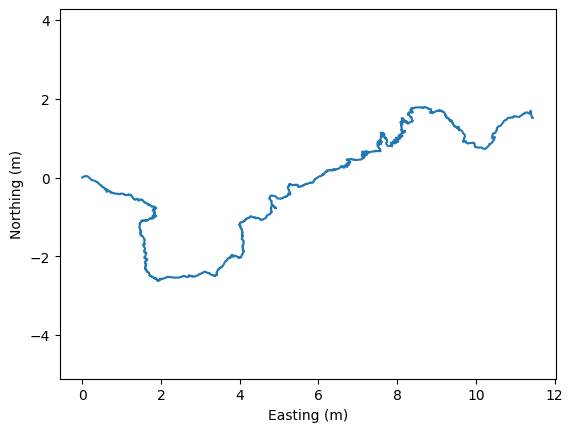

In [29]:
R = 6371  # raio da Terra (Km

teta_gps_0 = teta_gps[0]
phi_gps_0 = phi_gps[0]
phi_gps_mean = np.mean(phi_gps)

easting  = R * np.cos(phi_gps_mean) * (teta_gps - teta_gps_0)
northing = R * (phi_gps - phi_gps_0)

plt.figure()
plt.plot(easting, northing)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.axis("equal")
plt.show()


# Parte computacional da Questão 1.3


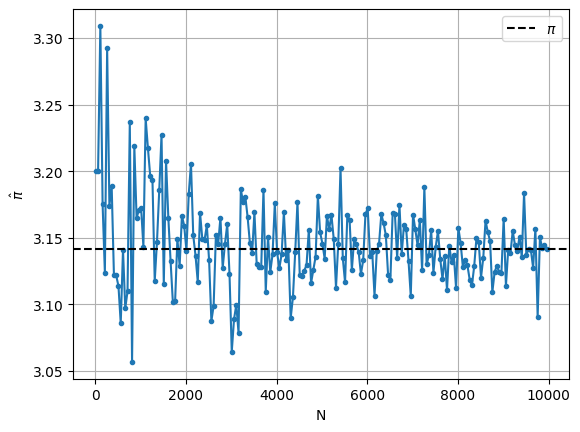

In [70]:
np.random.seed(1002)
def monte_carlo_pi(N):
    x, y = np.random.uniform(0, 2, size= (2, N) )
    mask = (x-1)**2 + (y-1)**2 < 1
    return sum(mask.astype(int))*4/N

# Gráifco em escala normal 

N_vals = np.arange(10, 10000, 50)
pi_vals = [monte_carlo_pi(N) for N in N_vals]

plt.figure()
plt.plot(N_vals, pi_vals, '.-')
plt.axhline(np.pi, color='k', linestyle='--', label=r'$\pi$')
plt.xlabel('N')
plt.ylabel(r'$\hat{\pi}$')
plt.grid()
plt.legend()
plt.show()




Agora vamos olhar o erro em escala logaritima e ralizar um ajuste de curva para observar a cara em que o erro cai.

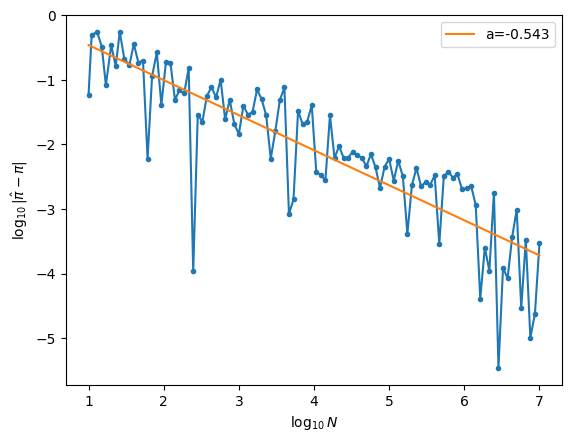

In [72]:
np.random.seed(1002)
# espaço logaritimo
N_vals = np.logspace(1,7, 100, dtype= int)
#print(len(N_vals), N_vals)

erro = np.abs(np.array([monte_carlo_pi(N) for N in N_vals])- np.pi)

#evitar os erros iguais a 0
index_dif_0 = erro > 0
log_N = np.log10(N_vals[index_dif_0])
log_erro = np.log10(erro[index_dif_0])

cof = np.polyfit(log_N, log_erro, 1)
a, b = cof

# curva ajustada
ajuste = b + log_N*a

plt.figure()
plt.plot(log_N, log_erro, '.-')
plt.plot(log_N, ajuste, '-', label = f"a={a:.3f}" )
plt.xlabel(r'$\log_{10} N$')
plt.ylabel(r'$\log_{10}|\hat{\pi} - \pi|$')

plt.legend()



plt.show()


Agora vamos resolver os problemas PIP. Em nosso código vamos remover os pontos que 

In [ ]:

"""
poligono shape
| x_1 y_1 |
| x_2 y_2 |
| x_3 y_3 |
   ....    
[[x,x,x,...][y,y,y...]]
(2,N)

"""
def cruzou(r1,r2, r):

def solve_pip_tracado(r, poly):
    y = r[1]
    y_poly = poly[1]
    mask_index = y != y_poly #usamos isso para retirar os pontos proximos a y
    count = np.zeros_like(y[mask_index])




[3]
